In [1]:
from core.activations import Fun
from core.losses import LossFun
from core.mlp import MLP

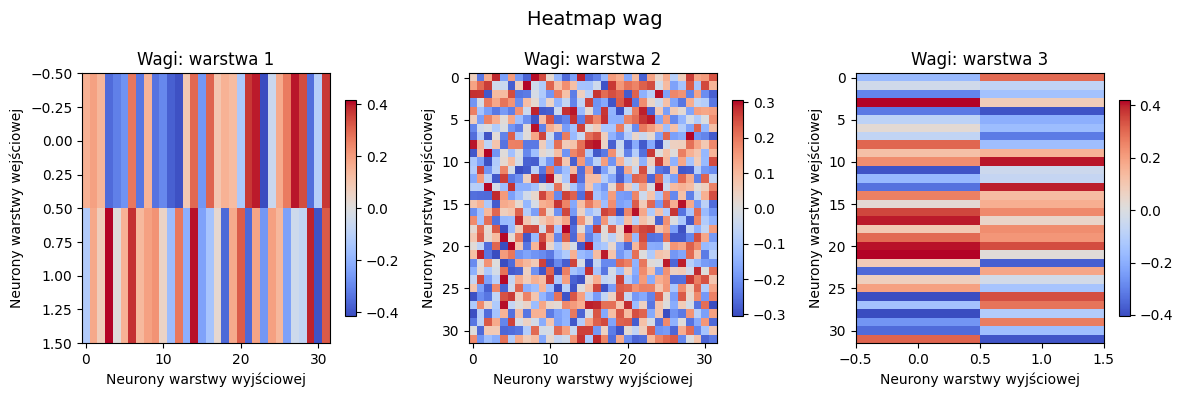

Epoka 500/5000, błąd treningowy: 0.138762, walidacyjny: 0.165171
Epoka 1000/5000, błąd treningowy: 0.086584, walidacyjny: 0.128439
Epoka 1500/5000, błąd treningowy: 0.073386, walidacyjny: 0.118282
Epoka 2000/5000, błąd treningowy: 0.067608, walidacyjny: 0.113651
Epoka 2500/5000, błąd treningowy: 0.063806, walidacyjny: 0.110044
Epoka 3000/5000, błąd treningowy: 0.061260, walidacyjny: 0.106325
Epoka 3500/5000, błąd treningowy: 0.059201, walidacyjny: 0.103569
Epoka 4000/5000, błąd treningowy: 0.057435, walidacyjny: 0.101044
Epoka 4500/5000, błąd treningowy: 0.055935, walidacyjny: 0.099894
Epoka 5000/5000, błąd treningowy: 0.054535, walidacyjny: 0.098896


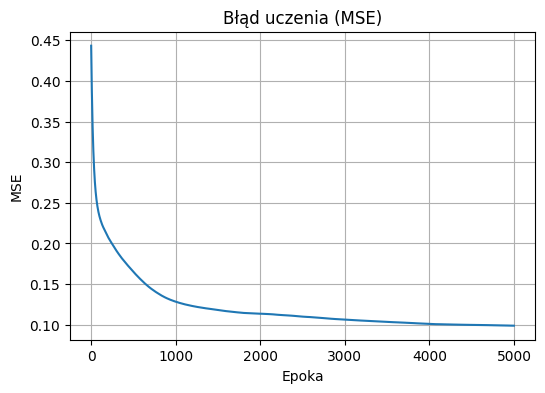

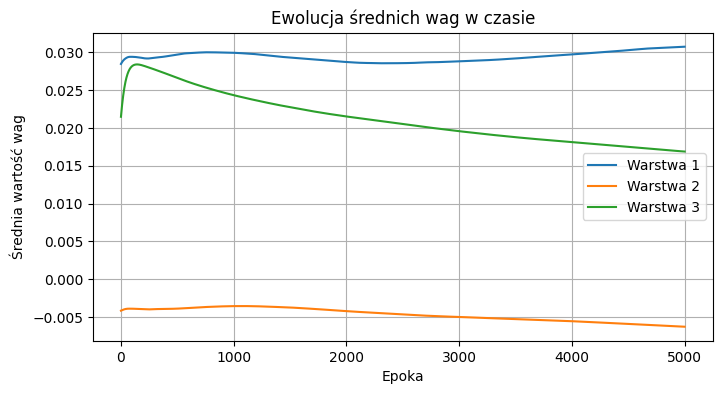

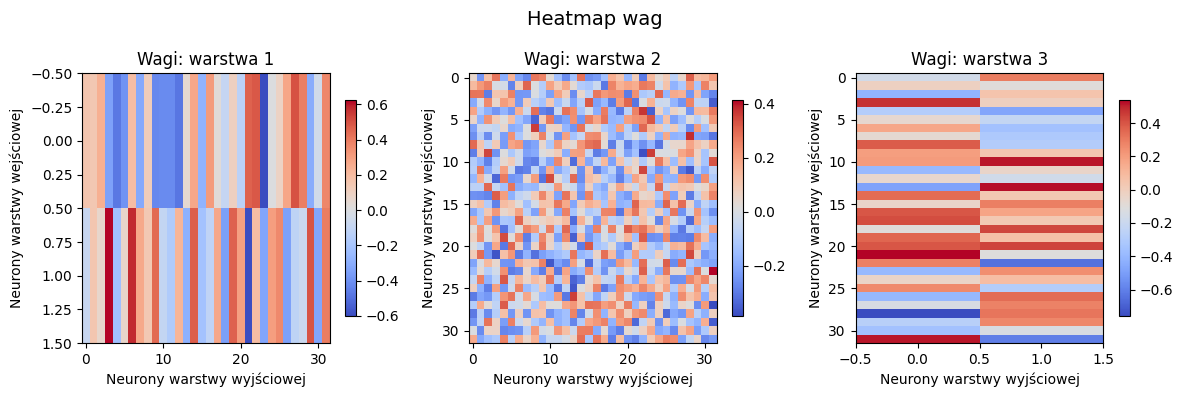

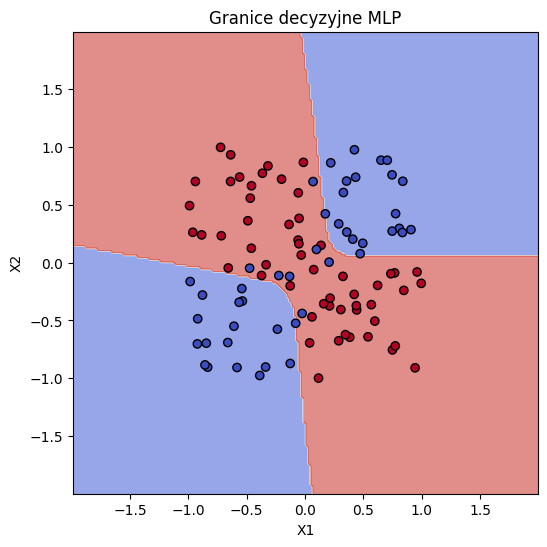

In [4]:
from plots.loss import make_loss_plot
from plots.classification.boundary import plot_decision_boundary
from data.classification import get_classification_data, Size, ClassificationType
from plots.weights import make_weights_avg_plot, make_weights_heatmap
from utils.split import split_data


X, y = get_classification_data(
    class_type=ClassificationType.NOISY_XOR, class_size=Size._100
)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

layer_sizes = [2, 32, 32, y.shape[1]]
activations = [Fun.ReLU, Fun.ReLU, Fun.Linear]
mlp = MLP(layer_sizes, activations, loss_fun=LossFun.MSE)

make_weights_heatmap(mlp)
weights_before = mlp.layers[0].W.copy()

epochs = 5000
learning_rate = 0.01
train_loss, val_loss, weights = mlp.train(X_train, y_train, X_val, y_val, epochs=epochs, learning_rate=learning_rate)

weights_after = mlp.layers[0].W.copy()

make_loss_plot(val_loss)
make_weights_avg_plot(weights)
make_weights_heatmap(mlp)

plot_decision_boundary(mlp, X, y)

In [23]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = mlp.forward(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred = np.eye(y_pred.shape[1])[y_pred_class]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.70      1.00      0.82         7

   micro avg       0.85      0.85      0.85        20
   macro avg       0.85      0.88      0.85        20
weighted avg       0.89      0.85      0.85        20
 samples avg       0.85      0.85      0.85        20



Epoka 500/5000, błąd treningowy: 0.288646, walidacyjny: 0.263998
Epoka 1000/5000, błąd treningowy: 0.286835, walidacyjny: 0.281986
Epoka 1500/5000, błąd treningowy: 0.264994, walidacyjny: 0.261730
Epoka 2000/5000, błąd treningowy: 0.247287, walidacyjny: 0.246911
Epoka 2500/5000, błąd treningowy: 0.191275, walidacyjny: 0.192485
Epoka 3000/5000, błąd treningowy: 0.124618, walidacyjny: 0.120659
Epoka 3500/5000, błąd treningowy: 0.099923, walidacyjny: 0.099847
Epoka 4000/5000, błąd treningowy: 0.087280, walidacyjny: 0.090609
Epoka 4500/5000, błąd treningowy: 0.076137, walidacyjny: 0.081449
Epoka 5000/5000, błąd treningowy: 0.061059, walidacyjny: 0.066104


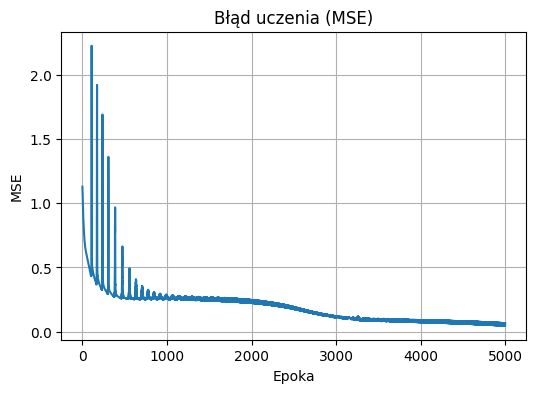

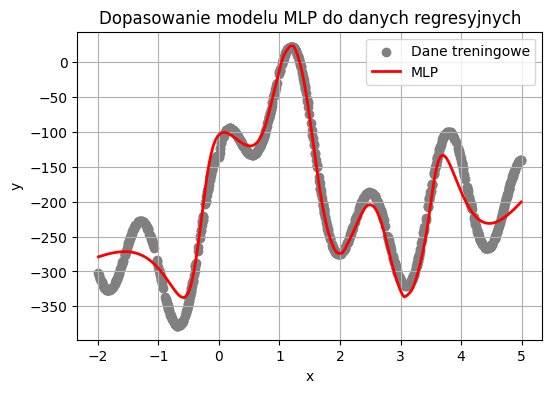

In [24]:
from data.regression import get_regression_data, Size, RegressionType
from utils.normalize import normalize
from plots.loss import make_loss_plot
from plots.regression.fit import make_fit_plot

X, Y = get_regression_data(class_type=RegressionType.MULTIMODAL, class_size=Size._1000)

Xn, X_mean, X_std = normalize(X)
Yn, Y_mean, Y_std = normalize(Y)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(Xn, Yn)

layer_sizes = [1, 64, 64, 32, 1]
activations = [Fun.ReLU, Fun.Tanh, Fun.Tanh, Fun.Linear]
mlp = MLP(layer_sizes, activations, loss_fun=LossFun.MSE)

epochs = 5000
learning_rate = 0.1
train_loss, val_loss, weights = mlp.train(X_train, y_train, X_val, y_val, epochs=epochs, learning_rate=learning_rate)

make_loss_plot(val_loss)
# make_weights_plot(weight_history)

make_fit_plot(X, Y, mlp)